### Counterparty Credit Risk Modeling by Standardized Approach
##### By Shicong Niu                                                                         
##### 2020.07

### Phase 1: Interest Rate Calculation

#### Background

There is a netting set consists of two interest rate products: “Interest Rate Swap” and “Interest Rate
Swaptions”. And this netting set is not approved for margining.

“Interest Rate Swap”:
1. There are 198 transactions under “Interest Rate Swap”.
2. There are 4 different hedging sets of these 198 transactions: “USD”, “CNY”, “CAD”, “GBP”.
3. These trades have different positions: “Pay fixed rate and receive floating rate” or “Pay floating rate and receive fixed rate”.

“Interest Rate Swaptions”:
1. There are 102 transactions under “Interest Rate Swaptions”.
2. There is only one hedging set of these 102 transactions: “EUR”
3. These trades have different positions: “Pay fixed rate and receive floating rate” or “Pay floating rate and receive fixed rate”. The Legs are those of the underlying swap.
4. These trades have different option types: “Call Option” or “Put Option”. 


In general, SACCR risk is captured by REplacement Cost(RC) and Potential Future Exposure(PFE)
                        
                        counterparty credit risk = 1.4 * (RC+PFE)

###### Replacement Cost for margined and unmargined transactions
    Unmargined transactions:
    RC = max (Market to Market - Collateral)
    Margined transactions:
    RC = max (Market to Market - Collateral, Threshold + Minimumu Transfer Amount − Net Independent Collateral Amount, 0)

###### PFE multiplier 
    Multiplier = min (1; 0.05 + 0.95 ∗ exp(Market to Market - Collateral / 2∗0.95∗ Addon))


#### Attribute Discriptions
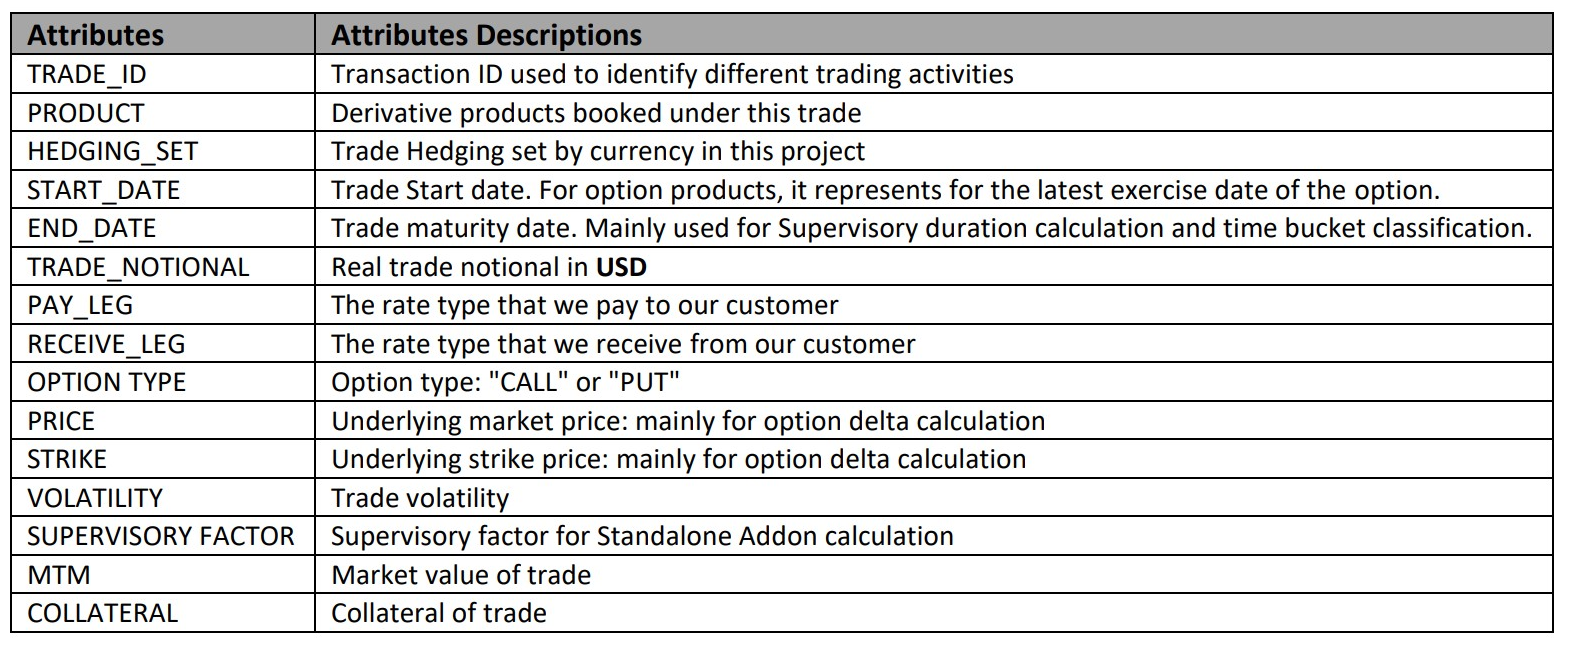

#### Goal of phase1
Calculate: Effective Notional, Standalone Addon, Replacement Cost, Potential Future Exposure and Exposure at Default in this netting set.


In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import norm
import logging


#### Preparations functions
The value of EAD is determined by Replacement cost(RC) and Potential Future Exposure(PFE).
In preperation phase, the goals are: 


#####  Position function: determine BUY/SELL position for each record

In [ ]:
 
def Position(df):
    
    # for option product, if we can short primary risk, we consider buy
    if df['OPTION TYPE']== "PUT" or df['OPTION TYPE']== "CALL":
        df["POSITION"]=="BUY"
    
    # for interest rate swap, if pay_leg fix rate then consider buy
    else:
        if df["PAY_LEG"] == "Fix" and df['RECEIVE_LEG'] == "Floating":
            df["POSITION"]=="BUY"
        elif df["PAY_LEG"] == "Floating" and df['RECEIVE_LEG'] == "Fix":
            df["POSITION"]=="SELL"
        # special cases
        else:
            df["POSITION"]=="Please Check With Trader"
    
    return df

  #####  sup_delta function: compute delta value
  
    Inputs: Interest Rate DataFrame
    output: Supervisory delta for each transactions

In [ ]:
def sup_delta(df):
    
    
    # calculate delta value according to option's type and position
    if df['PRODUCT'] == 'European swaption':
        # Black Shcoles Delta formula only apply for option products
        
        # For all product, mautirty date used for Delta calculation is the latest contractural exercise date
        df['T'] = np.where(df['START_DATE'] == 0, df['END_DATE'], df['START_DATE'])
        
        d1 = (np.log(df['PRICE']/df['STRIKE']) + (np.square(df['VOLATILITY'])/2)*\
                          df['T'])/(df['VOLATILITY']/np.sqrt(df['T']))
        
        # Calculate Put Supervisory Delta
        if df['OPTION TYPE'] == 'PUT':
            if df['POSITION'] == 'BUY':
                df['SUPERVISORY_DELTA'] = -norm.cdf(-d1)
            else:
                df['SUPERVISORY_DELTA'] = norm.cdf(-d1)
                
        # Calculate Call Supervisory Delta       
        if df['OPTION TYPE'] == 'CALL':
            if df['POSITION'] == 'BUY':
                df['SUPERVISORY_DELTA'] = norm.cdf(d1)
            else:
                df['SUPERVISORY_DELTA'] = -norm.cdf(d1)
    
    # Supervisory Delta for Interest rate Swap
    else:
        if df['POSITION'] == 'BUY':
            df['SUPERVISORY_DELTA'] = 1
        else:
            df['SUPERVISORY_DELTA'] = -1
            
    return df

#####  adjusted_notional function: compute adjusted notional amount and supervisory duration
    
    Input: netting set infomation
    
    outputs: Revised table with Supervisory Duration and Adjusted Notional added

In [2]:

def adjusted_notional(table):

    
    #abstract start date and end date:
    S = table['START_DATE']
    E = table['END_DATE']
    
    #supervisory duration calculation based on S and E 
    table['SUPERVISORY_DURATION'] = (np.exp(-0.05*np.array(S)) - \
                                         np.exp(-0.05*np.array(E)))/0.05

    table['ADJUSTED_NOTIONAL'] = table['TRADE_NOTIONAL']*table['SUPERVISORY_DURATION']
    return table




##### effective function: compute the effective notional value for each hedging set
    
    Inputs:
        D is a list which consists:
            D1: effective notional for bucket 1
            D2: effective notional for bucket 2
            D3: effective notional for bucket 3
        offset: True means banks choose to recognise offset across maturity buckets
        
    Output:
        e_notional: total effective notional amount within a bucket

In [ ]:
def effective(df):
    
    
    # effective notonal amount for each bucket (1,2,3)
    D1 = df[df['TIME_BUCKET'] == 1]['EFFECTIVE_NOTIONAL'].sum()
    D2 = df[df['TIME_BUCKET'] == 2]['EFFECTIVE_NOTIONAL'].sum()
    D3 = df[df['TIME_BUCKET'] == 3]['EFFECTIVE_NOTIONAL'].sum()
    
    base = np.square(D1)+np.square(D2)+np.square(D3)+1.4*D1*D2+1.4*D2*D3+0.6*D1*D3
    EFF_NOTIONAL = np.sqrt(base)
        
    df['EFF_NOTIONAL_HEGDE'] = EFF_NOTIONAL
    
    df['MTM_HEDGE'] = sum(df['MTM'])
    df['COLLATERAL_HEDGE'] = sum(df['COLLATERAL'])
    
    return df


#### Create an IR calculater 

 ##### Calculation function:  determine Positions, supervisory delta and Adjusted Notional
    
    Inputs:
        IR DataFrame: input from IR.xlsx file
    Output:
        DataFrame: hedging set information after some important attributes calculation

In [3]:
def Calculation(IR):
    

    
    # Use adjusted_notional function to compute Adjusted Notional and Supervisory Duration
    IR_Notional = adjusted_notional(IR)
    
    # Determine Buy and Sell Positions by property of 
    IR_Position = IR_Notional.apply(lambda x: Position(x), axis=1)
    
    # Calculate Supervisory Delta and Maturity Factor
    
    IR_ALL = IR_Position.apply(lambda x: sup_delta(x), axis=1)
    
    IR_ALL['MATURITY_FACTOR'] = np.sqrt(np.minimum(1,IR_ALL['END_DATE'])/1) 
    
    # Calculate Effective Notional 
    IR_ALL['EFFECTIVE_NOTIONAL'] = IR_ALL['ADJUSTED_NOTIONAL'] * \
                                    IR_ALL['MATURITY_FACTOR'] * IR_ALL['SUPERVISORY_DELTA']
    
    # Classify Time Bucket
    IR_ALL['TIME_BUCKET'] = np.where(IR_ALL['END_DATE']<=1, 1, 
                                      np.where((IR_ALL['END_DATE']>1) & (IR_ALL['END_DATE']<=5), 2, 3))
    
    
    return IR_ALL





##### Aggregate function: aggregate different hedging set.
    
    Inputs:
        IR DataFrame: output from Calculation function.
    Output:
        Hedging Set Results: output of effective notional, addon for different hedging set.
        Netting Set Results (Final): Output of RC and PFE
    

In [ ]:
def Aggregation(Inputs):
    
    
    Inputs = Inputs[['HEDGING_SET','TIME_BUCKET','EFFECTIVE_NOTIONAL','MTM','COLLATERAL']]
    
    Outputs = Inputs.groupby(['HEDGING_SET']).apply(effective)
    HEDGE_SET = Outputs[['HEDGING_SET','EFF_NOTIONAL_HEGDE',\
                           'MTM_HEDGE','COLLATERAL_HEDGE']].drop_duplicates(keep='first')
    HEDGE_SET['NETTING_SET'] = 'ABC'
    
    NETG_SET = HEDGE_SET.groupby(['NETTING_SET']).sum()
    NETG_SET['ADDON'] = NETG_SET['EFF_NOTIONAL_HEGDE'] * 0.005
    NETG_SET['PFE_MULTIPLIER'] = np.minimum(1, 0.05+(1-0.05)*\
                                    np.exp((NETG_SET['MTM_HEDGE']-NETG_SET['COLLATERAL_HEDGE'])\
                                           /(2*(1-0.05)*NETG_SET['ADDON'])))
    
	# Final Exposure  
    NETG_SET['SACCR_RC'] = np.maximum(0,NETG_SET['MTM_HEDGE']-NETG_SET['COLLATERAL_HEDGE'])
    NETG_SET['SACCR_PFE'] = NETG_SET['ADDON'] * NETG_SET['PFE_MULTIPLIER']
    NETG_SET['SACCR_EAD'] = 1.4*(NETG_SET['SACCR_RC']+NETG_SET['SACCR_PFE'])
    
    return HEDGE_SET, NETG_SET



### Phase2: Estimate ABC company counterparty risk


#### Background

Full transactions of ABC’s trading book have four different products. We want to estimate total exposure for ABC.

“Credit Default Swap”:
1. There are 228 transactions under “Credit Default Swap”.
2. There are different ratings for “Credit Default Swap” transactions from CCC to AAA rated by Moody’s agency.
3. We can see different positions for “Credit Default Swap” transactions: Protection buyer and Protection seller.

“Credit Default Swap Index”:
1. There are 72 transactions under “Credit Default Swap”.
2. There are different investment grades for “Credit Default Swap Index” transactions: InvestmentGrade and Sub-investment grade.
3. We can also see different positions for “Credit Default Swap Index” transactions: Protectionbuyer and Protection seller.

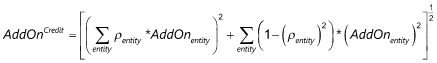
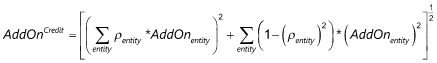


#### Attributes Discription
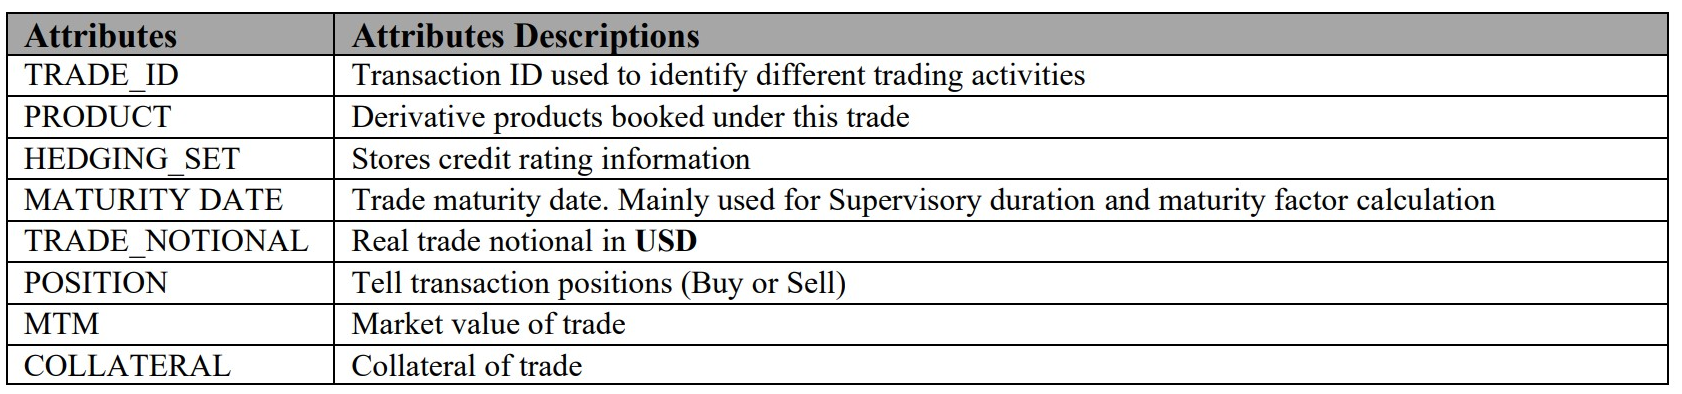

#### Goal of Phase 2
Consolidate Interest Rate risk and Credit risk together in order to estimate: Effective Notional, Standalone Addon, Replacement Cost, Potential Future Exposure and Exposure at Default for ABC company.

##### Calculation_CR function: determine Positions, supervisory delta and Adjusted Notional
    
    Inputs:
        IR DataFrame: input from Credit(1).xlsx file
    Output:
        DataFrame: hedging set information after some important attributes calculation

In [4]:

def Calculation_CR(CR, RF):
    
    
    CR['START_DATE'] = 0
    CR['END_DATE'] = CR['MATURITY DATE']
    
    # Calculate Adjusted Notional for All transactions 
    CR_Notional = adjusted_notional(CR)
    
    # Determine trade positions and supervisory delta
    CR_Notional['POSITION'] = np.where(CR_Notional['POSITION'] == 'Protection buyer', 'BUY', 'SELL')
    CR_ALL = CR_Notional.apply(lambda x: sup_delta(x), axis=1)
    
    # Supoervisory factor and Correlations
    CR_ALL['Credit Rating'] = np.where(CR_Notional['HEDGING_SET'] == 'Investment Grade', 'IG', \
          np.where(CR_Notional['HEDGING_SET'] == 'Sub-Investment Grade','SG', CR_ALL['HEDGING_SET']))

    
    CR_CALC = pd.merge(CR_ALL,RF,on = 'Credit Rating', how = 'inner')
    
    # Addon value for each trade
    CR_CALC['ADD_ON'] = CR_CALC['ADJUSTED_NOTIONAL']*CR_CALC['SUPERVISORY_DELTA']\
                                        *CR_CALC['Supervisory factor']
    
    return CR_CALC



##### CR_AGG function: aggregate Credit Exposure
    
    Inputs:
        CR DataFrame: output from Calculation_CR function.
    Output:
        Hedging Set Results: output of effective notional, addon for different hedging set.
        Netting Set Results (Final): Output of RC and PFE

In [ ]:
def CR_AGG(CR_CALC):
   
    
    # Calcaulate every term shown in the addon formula
    
    ## First Term
    CR_CALC['Addon*Correlation'] = CR_CALC['ADD_ON']*CR_CALC['Correlation']
    CR_CALC['Correlation^2'] = np.square(CR_CALC['Correlation'])
    
    ## Second Term
    CR_CALC['ADD_ON^2'] = np.square(CR_CALC['ADD_ON'])
    CR_CALC['1-Correlation^2'] = 1-CR_CALC['Correlation^2']
    CR_CALC['(1-Correlation^2)*ADD_ON^2'] = CR_CALC['ADD_ON^2']*CR_CALC['1-Correlation^2']
    
    ## Total Addon
    CR_CALC['NETTING_SET'] = 'ABC'
    HEDGE_SET = CR_CALC.groupby(['NETTING_SET'])['Addon*Correlation',\
                               '(1-Correlation^2)*ADD_ON^2','MTM','COLLATERAL']\
                               .sum().reset_index(drop = False)
    
    HEDGE_SET['TOTAL_ADDON^2'] = np.square(HEDGE_SET['Addon*Correlation']) \
                                            + HEDGE_SET['(1-Correlation^2)*ADD_ON^2']

    HEDGE_SET['TOTAL_ADDON'] = np.sqrt(HEDGE_SET['TOTAL_ADDON^2'])
    
    return HEDGE_SET

##### ABC_CALC function: calculate all exposure, including Interest Rate and Credit risk
    
    Inputs:
        IR DataFrame: output from CR and IR scripts
    Output:
        DataFrame: Exposures of ABC

In [5]:
def ABC_CALC(CR, IR, RF):
    
    """
    This function is to calculate all exposure, including Interest Rate and Credit risk
    
    Inputs:
        IR DataFrame: output from CR and IR scripts
    Output:
        DataFrame: Exposures of ABC
    
    """
    # Interest Rate
    Trade_Detail = Calculation(IR)
    
    HEDGE_SET, NETG_SET = Aggregation(Trade_Detail)
    
    NETG_SET = NETG_SET.rename(columns={'MTM_HEDGE':'MTM', 'COLLATERAL_HEDGE':'COLLATERAL'\
                             ,'ADDON':'TOTAL_ADDON'})
    # Credit
    CREDIT = Calculation_CR(CR, RF)
    
    CREDIT_RESULT = CR_AGG(CREDIT)
    
    # All
    Col = ['NETTING_SET','MTM','COLLATERAL','TOTAL_ADDON']
    ABC = NETG_SET[Col].append(CREDIT_RESULT[Col]).reset_index(drop = False)
    
    ABC = ABC.groupby(['NETTING_SET'])['MTM','COLLATERAL','TOTAL_ADDON']\
                            .sum().reset_index(drop = False)
                            
    ABC['PFE_MULTIPLIER'] = np.minimum(1, 0.05+(1-0.05)*\
                                    np.exp((ABC['MTM']-ABC['COLLATERAL'])\
                                           /(2*(1-0.05)*ABC['TOTAL_ADDON'])))
    
    ABC['SACCR_RC'] = np.maximum(0,ABC['MTM']-ABC['COLLATERAL'])
    ABC['SACCR_PFE'] = ABC['TOTAL_ADDON'] * ABC['PFE_MULTIPLIER']
    ABC['SACCR_EAD'] = 1.4*(ABC['SACCR_RC']+ABC['SACCR_PFE'])
    
    return NETG_SET, CREDIT_RESULT, ABC

#### Run the defined functions, obtain excel otput.

In [ ]:
if __name__ == '__main__':
    
    
    IR = pd.read_excel('Interest Rate.xlsx')
    CR = pd.read_excel('Credit.xlsx',sheetname='Credit')
    RF = pd.read_excel('Credit.xlsx',sheetname='Reference Table')

    IR, CR, ALL = ABC_CALC(CR, IR, RF)
    
    # Create a Pandas Excel writer using XlsxWriter as the engine.
    writer = pd.ExcelWriter('ABC.xlsx', engine='xlsxwriter')

    # Write each dataframe to a different worksheet.
    IR.to_excel(writer, sheet_name='IR', index = False)
    CR.to_excel(writer, sheet_name='CR', index = False)
    ALL.to_excel(writer, sheet_name='TOTAL EXPOSURE', index = False)
    
    # Close the Pandas Excel writer and output the Excel file.
    writer.save()